In [11]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

In [13]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline



In [14]:
from importlib import reload
reload(ck)

<module 'convnext_keras' from '/glade/u/home/ksha/NCAR/libs/convnext_keras.py'>

In [15]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch2/*neg_neg_neg*.npy"))
filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch2/*pos*.npy"))

In [16]:
filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch2/VALID*neg_neg_neg*.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch2/VALID*pos*.npy"))

In [17]:
filename_valid = filename_neg_valid + filename_pos_valid

In [21]:
#ind_pick_from_batch = [2, 11, 17, 18]

L_vars = 4
L_vars_h = 4
L_vars_ori = 19

In [22]:
np.load(filename_neg_train[0], allow_pickle=True)[()].keys()

dict_keys(['Gn3', 'Gn2', 'Gn1', 'Gp0', 'Gp1', 'Gp2', 'code'])

In [23]:
L_valid = len(filename_valid)

TEST_input = np.empty((L_valid, 6, 64))
TEST_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    
    collection = np.load(name, allow_pickle=True)[()]
    
    vector_gn3 = collection['Gn3']
    vector_gn2 = collection['Gn2']
    vector_gn1 = collection['Gn1']
    vector_gp0 = collection['Gp0']
    vector_gp1 = collection['Gp1']
    vector_gp2 = collection['Gp2']
    
    TEST_input[i, 0, :] = vector_gn3
    TEST_input[i, 1, :] = vector_gn2
    TEST_input[i, 2, :] = vector_gn1
    TEST_input[i, 3, :] = vector_gp0
    TEST_input[i, 4, :] = vector_gp1
    TEST_input[i, 5, :] = vector_gp2
    
    if 'pos' in name:
        TEST_target[i] = 1.0
    else:
        TEST_target[i] = 0.0

In [24]:
prob_base = np.sum(TEST_target) / len(TEST_target)

In [25]:
prob_base

0.005981511691136488

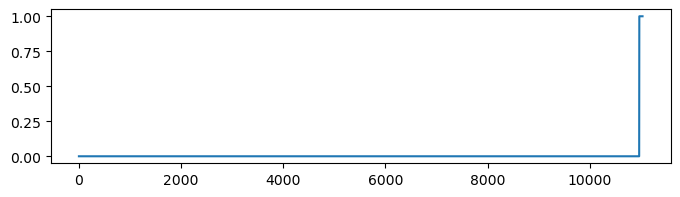

In [26]:
plt.figure(figsize=(8, 2))
plt.plot(TEST_target)

**ConvNext**

In [27]:
from sklearn.metrics import brier_score_loss

def verif_metric(VALID_target, Y_pred, thres=0.5):

    tn, fp, fn, tp = confusion_matrix(VALID_target.ravel(), Y_pred.ravel()>thres).ravel()

    CSI = tp/(tp+fn+fp)
    CSI_metric = 1 - CSI

    fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    AUC = auc(fpr, tpr)
    AUC_metric = 1 - AUC
    
    freq = (tp+fp)/(tp+fn)
    freq_metric = np.abs(freq-1.0)
    
    BS = brier_score_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{} {} {} {}'.format(CSI, AUC, freq, BS))
    metric = AUC_metric + 2*BS


    return metric


# def verif_metric(VALID_target, Y_pred, prob_base):
#     BS = np.mean((Y_pred.ravel()-VALID_target.ravel())**2)
#     BSS = 1-(BS/prob_base)
#     print('BS = {}; BSS = {}'.format(BS, BSS))
#     return BS/prob_base

In [28]:
from tensorflow.keras import Model

In [46]:
IN = tf.keras.Input(shape=(6, 64))

X = IN

X = tf.keras.layers.Conv1D(64, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

X = tf.keras.layers.Conv1D(128, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

#X = tf.keras.layers.Dropout(0.1)(X)

X = tf.keras.layers.Conv1D(256, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

X = tf.keras.layers.Conv1D(512, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

X = tf.keras.layers.GlobalMaxPool1D()(X)

OUT = X

OUT = layers.Dense(128)(OUT)
OUT = layers.Activation("gelu")(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6)(OUT)

OUT = layers.Dense(64)(OUT)
OUT = layers.Activation("gelu")(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6)(OUT)

OUT = layers.Dense(1, activation='sigmoid')(OUT)

model = Model(inputs=IN, outputs=OUT)

In [47]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience
epochs = 500
L_train = 200
batch_size = 100
batch_size_half = 50

In [68]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'SEQ_6'

model_name = '{}_pp4_tune'.format(key)
model_path = temp_dir+model_name

W_new = model.get_weights()
W_old = k_utils.dummy_loader(temp_dir+'SEQ_6_pp4')

for l in range(len(W_new)):
    if W_new[l].shape == W_old[l].shape:
        W_new[l] = W_old[l]

model.set_weights(W_new)


In [69]:
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.SGD(lr=1e-5))

In [70]:
X_batch = np.empty((batch_size, 6, 64))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

In [71]:
Y_pred = model.predict([TEST_input,])

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [72]:
Y_pred[Y_pred<0] = 0
Y_pred[Y_pred>1] = 1
record_temp = verif_metric(TEST_target, Y_pred)
record = record_temp
print("Initial record: {}".format(record))

0.03745318352059925 0.8309172137126185 3.196969696969697 0.019128199800334443
Initial record: 0.2073391858880504


In [73]:
#verif_metric(TEST_target, Y_pred, thres=0.5)

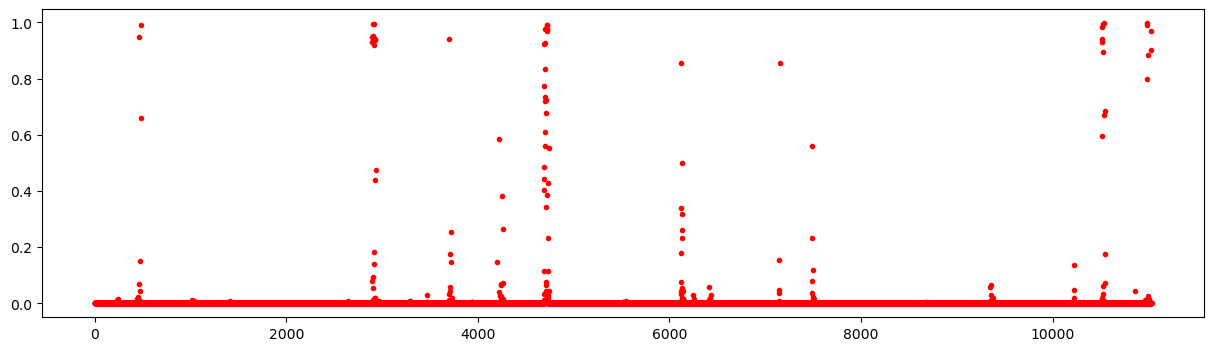

In [78]:
plt.figure(figsize=(15, 4))
#plt.plot(TEST_target[:], 'b-', lw=3.0)
plt.plot(Y_pred[:], 'r.')
#plt.plot(Y_pred>0.5)

In [75]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [77]:
# ========== Training loop ========== #



for i in range(epochs):
    
    shuffle(filename_neg_train)
    shuffle(filename_pos_train)
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        N_aug = int(np.random.uniform(1, 10))
        N_storm = 100 - N_aug

        L_storm = len(filename_neg_train)
        L_aug = len(filename_pos_train)
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_train[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_pos_train[ind_temp])
        
        file_pick = file_pick_storm + file_pick_aug
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):
            
            collection = np.load(file_pick[k], allow_pickle=True)[()]
            
            vector_gn2 = collection['Gn3']
            vector_gn2 = collection['Gn2']
            vector_gn1 = collection['Gn1']
            vector_gp0 = collection['Gp0']
            vector_gp1 = collection['Gp1']
            vector_gp2 = collection['Gp2']
            
            X_batch[k, 0, :] = vector_gn3
            X_batch[k, 1, :] = vector_gn2
            X_batch[k, 2, :] = vector_gn1
            X_batch[k, 3, :] = vector_gp0
            X_batch[k, 4, :] = vector_gp1
            X_batch[k, 5, :] = vector_gp2

            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.9999, 1.0)
            elif 'neg_neg_neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.0, 0.0001)
            else:
                werhgaer
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    Y_pred[Y_pred<0.0] = 0
    Y_pred[Y_pred>1] = 1
    #Y_pred = Y_pred[:, -1]
    
    record_temp = verif_metric(TEST_target, Y_pred)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.5):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04411764705882353 0.8012620736909577 1.1515151515151516 0.010629521413588788
Validation loss 0.21999696913621988 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05128205128205128 0.784761592953606 0.8636363636363636 0.008987922875759865
Validation loss 0.2332142527979137 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7755833775390668 0.7272727272727273 0.008283001070952681
Validation loss 0.24098262460283856 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7748132307760318 0.7272727272727273 0.008269539100224403
Validation loss 0.241725847424417 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.056074766355140186 0.7742060926552174 0.7121212121212122 0.00823177764698567
Validation loss 0.2422574626387539 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05714285714285714 0.7726471498353337 0.6818181818181818 0.008148931579609142
Validation loss 0.2436507133238846 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.056074766355140186 0.7727783856066132 0.7121212121212122 0.008207313425103398
Validation loss 0.24363624124359362 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.7696356342417612 0.6212121212121212 0.008093345071319731
Validation loss 0.24655105590087828 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.7675289547554318 0.6212121212121212 0.008001970610711411
Validation loss 0.248474986465991 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.7684710894503017 0.6212121212121212 0.008047942537291875
Validation loss 0.24762479562428202 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05454545454545454 0.7743504520036248 0.7575757575757576 0.008541276646293826
Validation loss 0.2427321012889628 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05454545454545454 0.7738814567999469 0.7575757575757576 0.008512238719135454
Validation loss 0.243143020638324 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.056074766355140186 0.7703857502818114 0.7121212121212122 0.008263753044599977
Validation loss 0.2461417558073885 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05714285714285714 0.769045763985589 0.6818181818181818 0.008170576974798692
Validation loss 0.2472953899640084 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05660377358490566 0.7690609597064739 0.696969696969697 0.008183285261328322
Validation loss 0.2473056108161827 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05263157894736842 0.7536449008686427 0.5151515151515151 0.007610578250064639
Validation loss 0.2615762556314866 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.061224489795918366 0.7546581791658378 0.5757575757575758 0.0076546664978803265
Validation loss 0.2606511538299229 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06060606060606061 0.7604974802731914 0.5909090909090909 0.007769565410160475
Validation loss 0.2550416505471295 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7708402404791901 0.7272727272727273 0.008360607280197798
Validation loss 0.24588097408120552 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7713541321309374 0.7272727272727273 0.00840896808121994
Validation loss 0.24546380403150247 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.764500862011803 0.6212121212121212 0.00800052236242872
Validation loss 0.2515001827130544 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.7650527429657626 0.6212121212121212 0.008034799927461965
Validation loss 0.2510168568891613 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06060606060606061 0.757746364078421 0.5909090909090909 0.007759553173213638
Validation loss 0.2577727422680063 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7593053068983047 0.6060606060606061 0.00780477633775812
Validation loss 0.25630424577721156 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7612033905797582 0.6060606060606061 0.007899238631623102
Validation loss 0.254595086683488 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05454545454545454 0.7754169153239174 0.7575757575757576 0.008597062319523405
Validation loss 0.2417772093151294 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05454545454545454 0.7745134606458457 0.7575757575757576 0.008580521253282677
Validation loss 0.24264758186071966 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.056074766355140186 0.768685210971863 0.7121212121212122 0.00829316325166551
Validation loss 0.24790111553146799 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.056074766355140186 0.7675759233472581 0.7121212121212122 0.008243447449730514
Validation loss 0.24891097155220293 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.762996485644188 0.6212121212121212 0.008058352772933272
Validation loss 0.25312021990167854 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7603096059058859 0.6060606060606061 0.007947848920675014
Validation loss 0.2555860919354641 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7586767566253343 0.6060606060606061 0.007891081063858253
Validation loss 0.2571054055023822 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7711883606303738 0.7272727272727273 0.008443906336666166
Validation loss 0.24569945204295857 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7698918893530491 0.7272727272727273 0.008402397149684151
Validation loss 0.2469129049463192 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7710826812987646 0.7272727272727273 0.008437455630412611
Validation loss 0.24579222996206065 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05454545454545454 0.7751910516543996 0.7575757575757576 0.00855281345634269
Validation loss 0.24191457525828577 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7698525186216653 0.7272727272727273 0.008404427401371314
Validation loss 0.24695633618107737 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7713596578476227 0.7272727272727273 0.008457190339476606
Validation loss 0.24555472283133048 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.056074766355140186 0.7693717812700307 0.7121212121212122 0.008386218127393884
Validation loss 0.24740065498475708 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05504587155963303 0.7745935835377848 0.7424242424242424 0.008531858091254303
Validation loss 0.24247013264472375 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05660377358490566 0.7661689377362244 0.696969696969697 0.008245148194989928
Validation loss 0.25032135865375543 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7708001790332206 0.7272727272727273 0.008429245763847971
Validation loss 0.24605831249447532 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.056074766355140186 0.7692122262007384 0.7121212121212122 0.008386659575522351
Validation loss 0.24756109295030634 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.057692307692307696 0.7634136772539398 0.6666666666666666 0.008172405781533852
Validation loss 0.2529311343091279 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7584032336494043 0.6060606060606061 0.007937501281552337
Validation loss 0.2574717689137004 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05263157894736842 0.7793367205976616 0.8181818181818182 0.00877290304553548
Validation loss 0.23820908549340938 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.056074766355140186 0.7673742346882391 0.7121212121212122 0.00829087282083076
Validation loss 0.24920751095342245 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.058823529411764705 0.7613456777844085 0.6363636363636364 0.0080919690140031
Validation loss 0.2548382602435977 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05660377358490566 0.7649622593550385 0.696969696969697 0.008253678052854195
Validation loss 0.25154509675066994 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7725297283557677 0.7272727272727273 0.008444747553280138
Validation loss 0.24435976675079255 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7569665473111862 0.6060606060606061 0.007917909164103466
Validation loss 0.25886927101702073 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.7594033883694715 0.6212121212121212 0.008020353493328353
Validation loss 0.2566373186171852 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.058823529411764705 0.7620101452158345 0.6363636363636364 0.008140917507216922
Validation loss 0.2542716897985993 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05172413793103448 0.7811512278142475 0.8484848484848485 0.008945747487994017
Validation loss 0.23674026716174051 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7724578940388568 0.7272727272727273 0.00842300955684281
Validation loss 0.24438812507482882 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05263157894736842 0.7786011095639105 0.8181818181818182 0.008789704943561804
Validation loss 0.23897830032321313 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05454545454545454 0.7749106215326128 0.7575757575757576 0.008567134053198554
Validation loss 0.2422236465737843 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.058823529411764705 0.7602267201556041 0.6363636363636364 0.008102851659712655
Validation loss 0.2559789831638212 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.058823529411764705 0.7611426076962182 0.6363636363636364 0.008133047132729013
Validation loss 0.2551234865692398 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7551658543863139 0.6060606060606061 0.007819720169203336
Validation loss 0.2604735859520928 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.7602301737285326 0.6212121212121212 0.008067698836618828
Validation loss 0.25590522394470505 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05714285714285714 0.7634599551311805 0.6818181818181818 0.00819634717894741
Validation loss 0.25293273922671433 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.056074766355140186 0.7695479134893796 0.7121212121212122 0.00831135779179858
Validation loss 0.2470748020942176 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.056074766355140186 0.7704796874654644 0.7121212121212122 0.00833268060056869
Validation loss 0.24618567373567302 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.774278617686714 0.7272727272727273 0.008461983067751522
Validation loss 0.24264534844878902 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7745763156731427 0.7272727272727273 0.008478617554015848
Validation loss 0.24238091943488904 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05714285714285714 0.7643799869593086 0.6818181818181818 0.008209678645708145
Validation loss 0.25203937033210766 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.057692307692307696 0.7635642530336184 0.6666666666666666 0.008164246745614832
Validation loss 0.25276424045761126 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05454545454545454 0.7766008001237761 0.7575757575757576 0.008595781508759113
Validation loss 0.24059076289374215 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.7605527374400458 0.6212121212121212 0.008048296752610592
Validation loss 0.2555438560651754 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.057692307692307696 0.7646514377914815 0.6666666666666666 0.008181031729034298
Validation loss 0.25171062566658714 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.057692307692307696 0.7652399266184824 0.6666666666666666 0.008191302740350724
Validation loss 0.2511426788622191 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05172413793103448 0.7811940521185597 0.8484848484848485 0.008921094985536004
Validation loss 0.23664813785251226 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05714285714285714 0.7701232787392525 0.6818181818181818 0.008261353902058476
Validation loss 0.2463994290648645 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7579473620228544 0.6060606060606061 0.007915455498439208
Validation loss 0.257883548974024 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7601348551157083 0.6060606060606061 0.008006855223399773
Validation loss 0.2558788553310912 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05714285714285714 0.7706551289702275 0.6818181818181818 0.008257902063683646
Validation loss 0.24586067515713983 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7749486108348254 0.7272727272727273 0.008415310587562345
Validation loss 0.24188201034029932 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05714285714285714 0.7704520588820369 0.6818181818181818 0.008211113887083163
Validation loss 0.2459701688921294 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05660377358490566 0.7728115399067259 0.696969696969697 0.008293160655702856
Validation loss 0.2437747814046798 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05714285714285714 0.7722941946820503 0.6818181818181818 0.008243105006165706
Validation loss 0.24419201533028112 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7580703092191057 0.6060606060606061 0.007860556303803853
Validation loss 0.25765080338850205 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05660377358490566 0.7719619609663373 0.696969696969697 0.008276202543469937
Validation loss 0.24459044412060257 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05714285714285714 0.7713133799703822 0.6818181818181818 0.00826958609759663
Validation loss 0.24522579222481108 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.057692307692307696 0.7662165970426364 0.6666666666666666 0.008142504490426474
Validation loss 0.2500684119382165 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7595712320137922 0.6060606060606061 0.007958448168590933
Validation loss 0.2563456643233897 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.058823529411764705 0.7641147525584069 0.6363636363636364 0.00808665416569964
Validation loss 0.2520585557729924 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05714285714285714 0.7694007912826293 0.6818181818181818 0.008236151661305618
Validation loss 0.24707151203998196 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.057692307692307696 0.7686161395132949 0.6666666666666666 0.008215299306220386
Validation loss 0.2478144590991459 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7563987799217557 0.6060606060606061 0.007844091250184706
Validation loss 0.25928940257861366 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.061224489795918366 0.7543874190482507 0.5757575757575758 0.00775779257904503
Validation loss 0.26112816610983935 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.061224489795918366 0.7537934045045642 0.5757575757575758 0.007740054224667003
Validation loss 0.2616867039447698 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.7637396945383816 0.6212121212121212 0.008047242546944045
Validation loss 0.25235479055550647 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05714285714285714 0.7687929624472294 0.6818181818181818 0.008263128167835006
Validation loss 0.24773329388844062 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.774020290431669 0.7272727272727273 0.008433074519043312
Validation loss 0.24284585860641764 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.057692307692307696 0.767461264726035 0.6666666666666666 0.00817357473178697
Validation loss 0.2488858847375389 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.057692307692307696 0.7680580421280638 0.6666666666666666 0.008180542111391078
Validation loss 0.24830304209471832 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7639876610746413 0.6060606060606061 0.007990091950372716
Validation loss 0.25199252282610407 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7728357149172247 0.7272727272727273 0.00836675529072894
Validation loss 0.2438977956642332 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7608842804411733 0.6060606060606061 0.00797616248700396
Validation loss 0.2550680445328346 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7731347943328251 0.7272727272727273 0.008355939084407814
Validation loss 0.24357708383599058 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.7652005558870986 0.6212121212121212 0.008059861313010657
Validation loss 0.2509191667389227 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7634668622770373 0.6060606060606061 0.007993177980656298
Validation loss 0.2525194936842753 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7740935061777512 0.7272727272727273 0.008389984232866785
Validation loss 0.24268646228798238 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.057692307692307696 0.7668589616073205 0.6666666666666666 0.00815015115958176
Validation loss 0.24944134071184304 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.057692307692307696 0.7684427701522887 0.6666666666666666 0.008223094216555225
Validation loss 0.24800341828082179 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05825242718446602 0.7667484472736115 0.6515151515151515 0.008134690248119763
Validation loss 0.24952093322262806 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.057692307692307696 0.7663450699555733 0.6666666666666666 0.008147755716162951
Validation loss 0.24995044147675263 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.7640878146895653 0.6212121212121212 0.008051708382843782
Validation loss 0.2520156020761222 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.057692307692307696 0.7671614945958491 0.6666666666666666 0.008170862971194546
Validation loss 0.24918023134653994 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.061224489795918366 0.7548584863956855 0.5757575757575758 0.007788038465164712
Validation loss 0.2607175905346439 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7618319408527285 0.6060606060606061 0.007957483414688419
Validation loss 0.2540830259766483 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.061224489795918366 0.7553558008973764 0.5757575757575758 0.007778992579573455
Validation loss 0.2602021842617705 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.061224489795918366 0.7543556461773091 0.5757575757575758 0.007705190276468865
Validation loss 0.26105473437562865 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7611108348252769 0.6060606060606061 0.007877705696501284
Validation loss 0.2546445765677257 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.061224489795918366 0.7565010056804368 0.5757575757575758 0.007788454266438068
Validation loss 0.25907590285243937 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.764596180624627 0.6212121212121212 0.008006865122981975
Validation loss 0.251417549621337 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05454545454545454 0.7762070928099375 0.7575757575757576 0.00855451076398109
Validation loss 0.24090192871802468 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.057692307692307696 0.7681526700263024 0.6666666666666666 0.008207111826953179
Validation loss 0.24826155362760396 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.7644428419866057 0.6212121212121212 0.008042615900298254
Validation loss 0.2516423898139908 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.057692307692307696 0.7687915810180581 0.6666666666666666 0.008252902195172985
Validation loss 0.24771422337228785 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.061224489795918366 0.7561190405145547 0.5757575757575758 0.007799014363388254
Validation loss 0.2594789882122218 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.061224489795918366 0.7560582576310149 0.5757575757575758 0.007784930802026027
Validation loss 0.2595116039730372 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.061224489795918366 0.75615979267511 0.5757575757575758 0.007782384732541618
Validation loss 0.2594049767899732 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05434782608695652 0.7452299250712817 0.4696969696969697 0.007421245996865333
Validation loss 0.26961256692244895 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06060606060606061 0.7597653228123689 0.5909090909090909 0.007833970552999532
Validation loss 0.2559026182936302 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.058823529411764705 0.7657496739827155 0.6363636363636364 0.008108105344761043
Validation loss 0.2504665367068065 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.058823529411764705 0.7655224288840263 0.6363636363636364 0.008106394330300025
Validation loss 0.2506903597765737 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7620909588223592 0.6060606060606061 0.007936149800852636
Validation loss 0.25378134077934605 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.7631429171363526 0.6212121212121212 0.007997834896426973
Validation loss 0.2528527526565013 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06060606060606061 0.7598288685542515 0.5909090909090909 0.007839742064994522
Validation loss 0.25585061557573757 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.061224489795918366 0.7536124372831157 0.5757575757575758 0.007704399784485335
Validation loss 0.261796362285855 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.058823529411764705 0.765922352629136 0.6363636363636364 0.008097069431284729
Validation loss 0.2502717862334335 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.061855670103092786 0.7530267113144575 0.5606060606060606 0.007692217192556891
Validation loss 0.26235772307065625 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06060606060606061 0.7597473642331409 0.5909090909090909 0.007832392067524101
Validation loss 0.25591741990190725 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06 0.7632216585991203 0.6060606060606061 0.007982252178113965
Validation loss 0.25274284575710765 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.770438935304909 0.7272727272727273 0.00836703959108371
Validation loss 0.24629514387725837 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7721014853126451 0.7272727272727273 0.008467604412929902
Validation loss 0.2448337235132147 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7714605021771324 0.7272727272727273 0.008418747791489678
Validation loss 0.245376993405847 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.7647060042437503 0.6212121212121212 0.008031502146745237
Validation loss 0.25135700004974015 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.061224489795918366 0.7557129003381738 0.5757575757575758 0.007764456949991054
Validation loss 0.2598160135618083 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05660377358490566 0.769794498596468 0.696969696969697 0.008294959910735757
Validation loss 0.24679542122500353 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05825242718446602 0.7668831366178193 0.6515151515151515 0.008137193240190452
Validation loss 0.24939124986256164 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05660377358490566 0.7697005614128153 0.696969696969697 0.008286498194400131
Validation loss 0.246872434975985 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06060606060606061 0.7616247264770241 0.5909090909090909 0.007883193013666552
Validation loss 0.25414165955030904 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06060606060606061 0.7608718475786309 0.5909090909090909 0.007846951294913347
Validation loss 0.25482205501119576 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06060606060606061 0.7619217337488673 0.5909090909090909 0.007856213800655123
Validation loss 0.25379069385244296 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.772919982096678 0.7272727272727273 0.00836385558235653
Validation loss 0.24380772906803505 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.057692307692307696 0.7696895099794443 0.6666666666666666 0.00820453867998082
Validation loss 0.24671956738051734 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7752000309440135 0.7272727272727273 0.008426217293073218
Validation loss 0.24165240364213297 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0594059405940594 0.7669715480847866 0.6212121212121212 0.008027471797034202
Validation loss 0.24908339550928177 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05825242718446602 0.769152134031784 0.6515151515151515 0.008183030246712844
Validation loss 0.24721392646164173 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7732784629666467 0.7272727272727273 0.008413967945596288
Validation loss 0.24354947292454587 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05660377358490566 0.7711593506177751 0.696969696969697 0.00828063087787946
Validation loss 0.24540191113798385 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05555555555555555 0.7770207545918706 0.7272727272727273 0.008510864840518873
Validation loss 0.24000097508916715 NOT improved



KeyboardInterrupt



In [ ]:
model.save(model_path)

0.07216494845360824 0.8547555871923765 1.5060240963855422 0.008271191126251975

Validation loss improved from 0.16323948442990924 to 0.16178679506012741

save to: /glade/work/ksha/NCAR/Keras_models/SEQ_S_pp4_tune5

INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SEQ_S_pp4_tune5/assets

In [ ]:
import tf.keras.backend as K

In [ ]:
def custom_loss(y_true, y_pred):
            
    y_pred_neg = y_pred[y_true == 0]
    y_pred_pos = y_pred[y_true == 1]
    
    loss = 0.1*K.mean(y_pred_neg) + K.mean(K.abs(y_pred_pos-1))
        
    return loss